In [1]:
import keras
import cv2
import collections
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from keras.optimizers import Adam
from keras.models import Sequential
from keras import datasets, layers, models
from keras.utils import to_categorical
from keras import regularizers
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt


2025-02-18 00:45:11.547781: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-18 00:45:11.548262: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-18 00:45:11.551117: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-18 00:45:11.560923: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739850311.577831   70344 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739850311.58

In [2]:
import struct
import gzip

def load_images(filename):
    """Carrega imagens do arquivo .idx3-ubyte.gz"""
    with gzip.open(filename, 'rb') as f:
        _, num_images, rows, cols = struct.unpack(">IIII", f.read(16))  # Lê o cabeçalho do arquivo
        images = np.frombuffer(f.read(), dtype=np.uint8)  # Lê os pixels
        images = images.reshape(num_images, rows, cols)  # Formata como imagens 28x28
    return images

def load_labels(filename):
    """Carrega labels do arquivo .idx1-ubyte.gz"""
    with gzip.open(filename, 'rb') as f:
        _, num_labels = struct.unpack(">II", f.read(8))  # Lê o cabeçalho do arquivo
        labels = np.frombuffer(f.read(), dtype=np.uint8)  # Lê os labels
    return labels


In [3]:
# Caminhos dos arquivos
train_images_path = "data/train-images-idx3-ubyte.gz"
train_labels_path = "data/train-labels-idx1-ubyte.gz"
test_images_path = "data/t10k-images-idx3-ubyte.gz"
test_labels_path = "data/t10k-labels-idx1-ubyte.gz"

# Carregando as imagens e labels
X_train = load_images(train_images_path)
y_train = load_labels(train_labels_path)
X_test = load_images(test_images_path)
y_test = load_labels(test_labels_path)

# Verificando os formatos
print("X_train shape:", X_train.shape)  # Deve ser (60000, 28, 28)
print("y_train shape:", y_train.shape)  # Deve ser (60000,)
print("X_test shape:", X_test.shape)    # Deve ser (10000, 28, 28)
print("y_test shape:", y_test.shape)    # Deve ser (10000,)


X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [4]:
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

In [5]:
# Codificação one-hot das etiquetas
NUM_CLASSES = 10  # Fashion MNIST tem 10 classes (0-9)
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

# Nome das classes (rótulos do Fashion MNIST)
CLASS_NAMES = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Visualizando as etiquetas
for i, class_name in enumerate(CLASS_NAMES):
    print(f"{i}: {class_name}")

print(f"Class Names: {CLASS_NAMES}")


0: T-shirt/top
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot
Class Names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


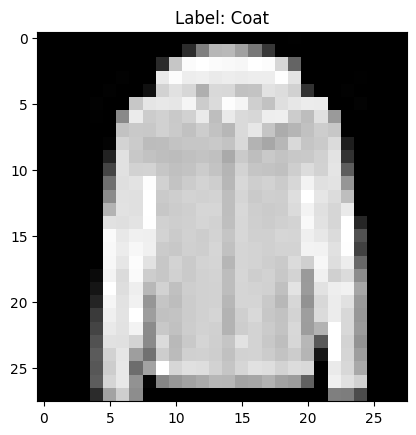

In [6]:
# Exemplo de visualização de uma imagem
plt.imshow(X_train[5000], cmap="gray")
plt.title(f"Label: {CLASS_NAMES[np.argmax(y_train[5000])]}")
plt.show()

In [7]:
# Criando um modelo CNN para Fashion MNIST com Dropout
model = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),  # Definindo a entrada corretamente

    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),  # Dropout após a primeira camada convolucional

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),  # Dropout após a segunda camada convolucional

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout antes da camada de saída

    layers.Dense(10, activation='softmax')  # 10 classes para Fashion MNIST
])

# Compilando o modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Exibindo a arquitetura do modelo
model.summary()


2025-02-18 00:45:14.297443: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=250,
    validation_data=(X_test, y_test)
)

Epoch 1/250
938/938 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.6683 - loss: 0.9070 - val_accuracy: 0.8375 - val_loss: 0.4327
Epoch 2/250
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.8325 - loss: 0.4614 - val_accuracy: 0.8660 - val_loss: 0.3623
Epoch 3/250
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.8552 - loss: 0.4016 - val_accuracy: 0.8798 - val_loss: 0.3291
Epoch 4/250
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.8678 - loss: 0.3632 - val_accuracy: 0.8896 - val_loss: 0.2996
Epoch 5/250
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.8809 - loss: 0.3349 - val_accuracy: 0.8932 - val_loss: 0.2889
Epoch 6/250
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.8835 - loss: 0.3199 - val_accuracy: 0.8944 - val_loss: 0.2873
Epoch 7/250
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.8897 - loss: 0.3045 - val_accuracy: 0.9011 - val_loss: 0.2688
Epoch 8/250
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.8897 - loss: 0

Text(0.5, 1.0, 'Curvas de perda')

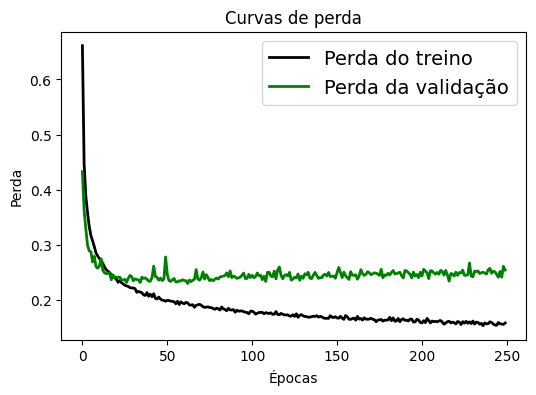

In [14]:
""" Curva de perda """

plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Perda do treino', 'Perda da validação'], fontsize=14)
plt.xlabel('Épocas', fontsize=10)
plt.ylabel('Perda', fontsize=10)
plt.title('Curvas de perda', fontsize=12)

Text(0.5, 1.0, 'Curva de acurácia')

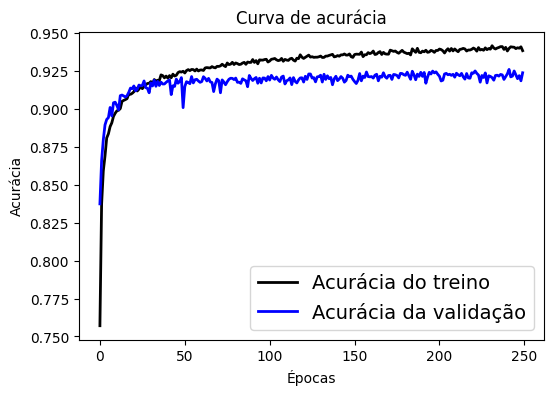

In [15]:
""" Curva de acurácia """
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Acurácia do treino', 'Acurácia da validação'], fontsize=14)
plt.xlabel('Épocas', fontsize=10)
plt.ylabel('Acurácia', fontsize=10)
plt.title('Curva de acurácia', fontsize=12)

In [11]:
""" Previsões """

# Fazendo as previsões
pred = model.predict(X_test)
print(pred)

# Convertendo as previsões nos índices das etiquetas
pred_classes = np.argmax(pred, axis=1)
print(pred_classes)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[[1.8019583e-32 2.3798419e-32 1.6606970e-36 ... 4.5973694e-11
  7.4320900e-28 1.0000000e+00]
 [1.1532164e-12 1.1079615e-34 1.0000000e+00 ... 0.0000000e+00
  9.8259725e-25 0.0000000e+00]
 [1.4831519e-29 1.0000000e+00 8.7349825e-37 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [1.7087616e-26 0.0000000e+00 1.3419947e-34 ... 0.0000000e+00
  1.0000000e+00 0.0000000e+00]
 [2.7923139e-23 1.0000000e+00 9.8514860e-27 ... 0.0000000e+00
  1.8597439e-28 0.0000000e+00]
 [3.1934115e-07 3.7457651e-13 5.8413474e-10 ... 6.8861055e-03
  9.8892860e-06 8.5373445e-05]]
[9 2 1 ... 8 1 5]


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


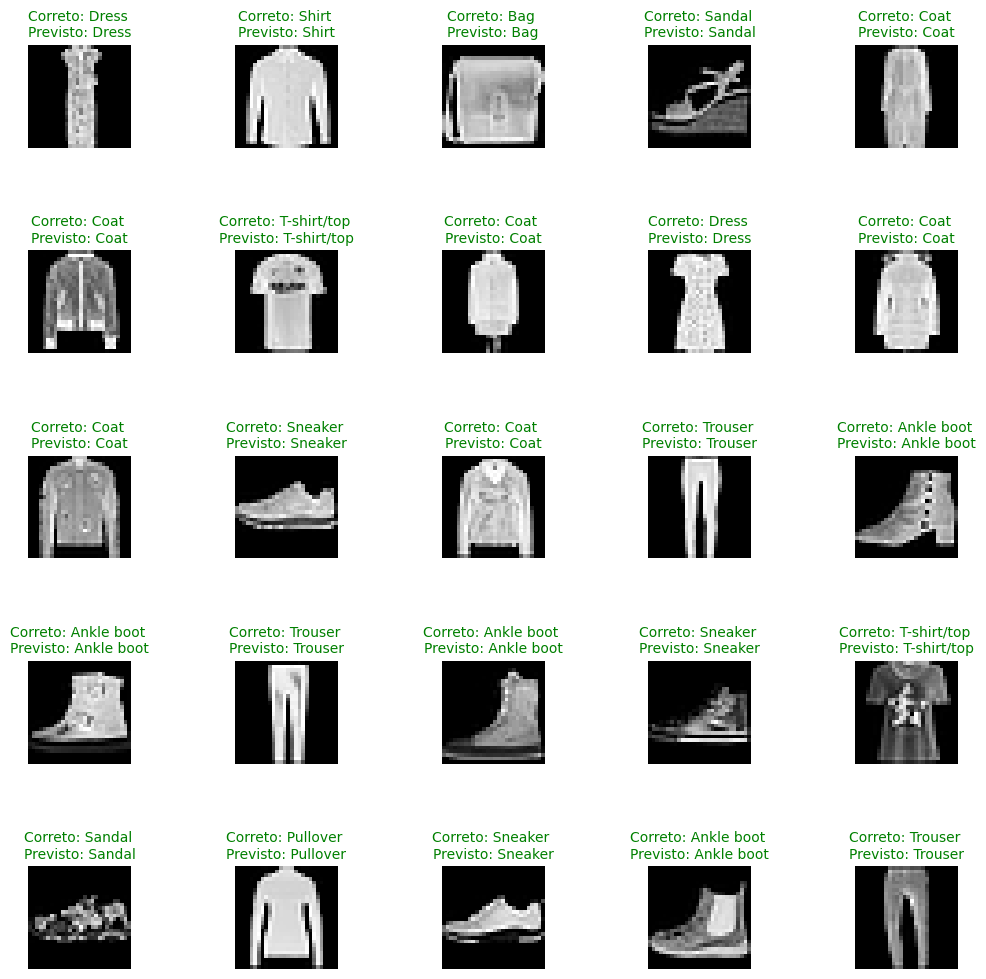

In [12]:
# Fazendo previsões no conjunto de teste
pred_probs = model.predict(X_test)  # Obtendo probabilidades das classes
pred_classes = np.argmax(pred_probs, axis=1)  # Pegando a classe com maior probabilidade
true_classes = np.argmax(y_test, axis=1)  # Pegando os rótulos reais

# Criando uma grade 5x5 para exibir imagens comparadas
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
axes = axes.ravel()

for i in np.arange(0, 25):  # Mostrando 25 imagens aleatórias
    random_num = np.random.choice(len(X_test))  # Pegando um índice aleatório

    axes[i].imshow(X_test[random_num], cmap='gray')  # Exibindo a imagem
    axes[i].set_title(f"Correto: {CLASS_NAMES[true_classes[random_num]]} \nPrevisto: {CLASS_NAMES[pred_classes[random_num]]}",
                      fontsize=10, color=("green" if true_classes[random_num] == pred_classes[random_num] else "red"))
    axes[i].axis('off')

plt.subplots_adjust(wspace=1, hspace=1)
plt.show()


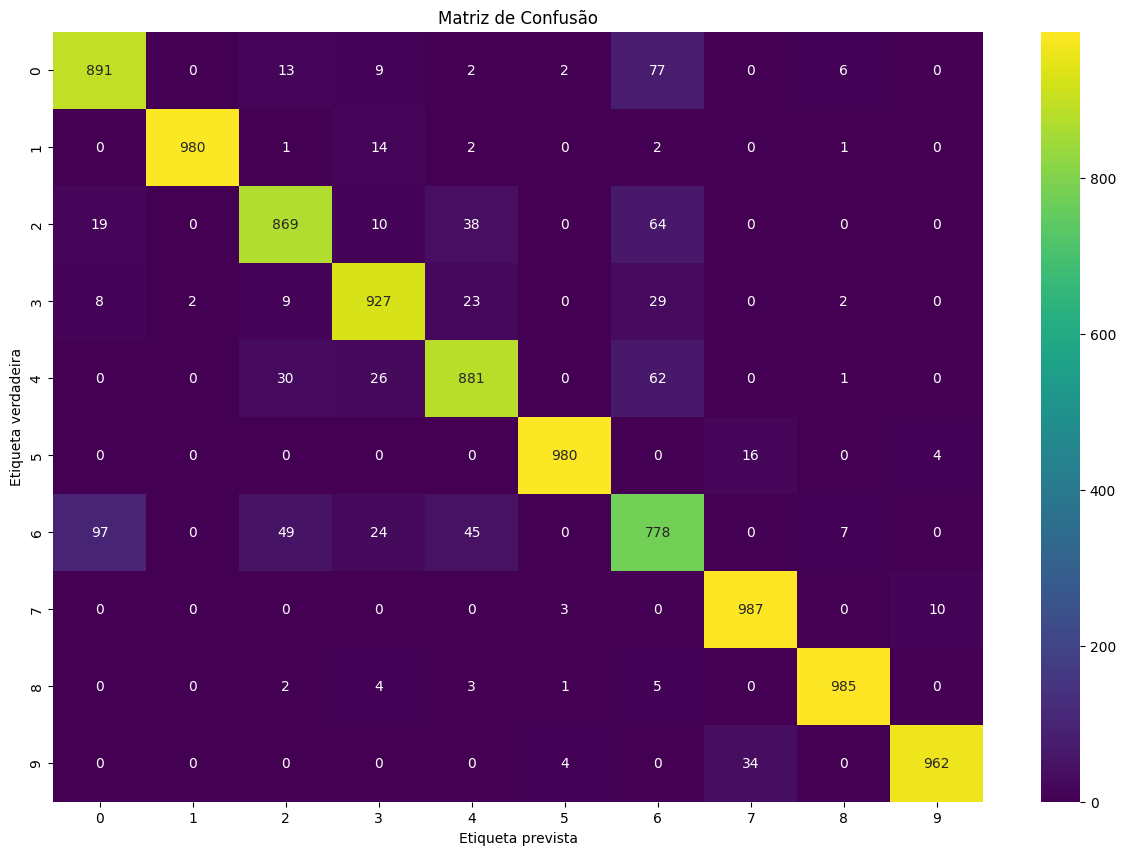

In [13]:
""" Matriz de confusão """

confusion_mtx = confusion_matrix(np.argmax(y_test, axis=1), pred_classes)

# Plota a matriz de confusão
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(confusion_mtx, annot=True, fmt="d", ax=ax, cmap="viridis")
ax.set_xlabel("Etiqueta prevista")
ax.set_ylabel("Etiqueta verdadeira")
ax.set_title("Matriz de Confusão");